In [4]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [5]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 32

In [6]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [14]:
def get_euclid_dis_tips_and_palm_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
    hand_name = ['left', 'right']
    
    fingertip_pos = np.zeros([2, 5, 3])
    
    hand_palm_pos = np.zeros([2, 3])
    hand_palm_rpy = np.zeros([2, 3])
    dist_fingertip_palm = np.zeros([10])
    dist_btw_fingertip = np.zeros([10])
    
    feature = np.zeros([2*3 + 2*3 + 10 + 10])
    
    for hand_idx, hand in enumerate(hand_name):
        if not hand in frame['hands']:
            continue
        hand_palm_pos[hand_idx] = np.array(frame['hands'][hand]['hand_palm_position'])
        hand_palm_rpy[hand_idx] = np.array([ frame['hands'][hand]['roll'],
                                                    frame['hands'][hand]['pitch'],
                                                    frame['hands'][hand]['yaw']])
        for finger_idx, finger in enumerate(finger_name):
            fingertip_pos[hand_idx, finger_idx] = (
                np.array(frame['hands'][hand]['fingers'][finger]['bones']['distal']['next_joint'])
            )
            
            dist_fingertip_palm[hand_idx*5 + finger_idx] = np.linalg.norm(
                fingertip_pos[hand_idx, finger_idx] - hand_palm_pos[hand_idx]
            )
            
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    dist_btw_fingertip = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2)
        
    feature[0:6] = hand_palm_pos.reshape(6)
    feature[6:12] = hand_palm_rpy.reshape(6)
    feature[12:22] = dist_fingertip_palm.T
    feature[22:32] = dist_btw_fingertip.reshape(10)
    
#     print(feature[12+5:12+6])
#     print(frame['hands']['right']['fingers']['thumb']['bones']['distal']['next_joint'])
#     print(hand_palm_pos[1])
    return feature
    

In [8]:
def get_timesteps(json_data, pick_frame_every_no): 
    timesteps = np.zeros([0, dimensions])
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']:
            continue
#         feature = get_feature(frame)
        feature = get_euclid_dis_tips_and_palm_feature(frame)
        timesteps = np.vstack((timesteps, feature))
    return timesteps

In [9]:
def get_fake_speedup_timesteps_1(percent, json_data, pick_frame_every_no):
    return get_timesteps(json_data, pick_frame_every_no*(100+percent)//100)

In [10]:
def get_fake_speedup_timesteps_2(percent, old_timesteps, old_pick_frame_every_no):
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = old_pick_frame_every_no*(100+percent)//100
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps
        
    

In [11]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [12]:
speedup = 10
pick_frame_every_no = int((max_frame * (speedup < 0 and (100-speedup)/100 or 1)) // 50 + 1)

In [15]:
x = np.zeros([0, timesteps, dimensions])
y = np.zeros([0])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)
        
        _timesteps = get_fake_speedup_timesteps_2(+10, _timesteps, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)

In [16]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [17]:
x_train = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 // 3])
x_test = np.zeros([data_length // 3, timesteps, dimensions])
y_test = np.zeros([data_length // 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx // 3] = x_norm[idx]
        y_test[idx // 3] = y[idx]
    else:
        x_train[idx - idx // 3] = x_norm[idx]
        y_train[idx - idx // 3] = y[idx]

In [18]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 // 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [19]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [20]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 684 samples, validate on 342 samples
Epoch 1/1000
684/684 [==============================] - 6s 9ms/step - loss: 2.9860 - acc: 0.0395 - val_loss: 2.9403 - val_acc: 0.0702
Epoch 2/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.9430 - acc: 0.0658 - val_loss: 2.7888 - val_acc: 0.0877
Epoch 3/1000
684/684 [==============================] - 3s 5ms/step - loss: 2.8344 - acc: 0.0863 - val_loss: 2.6340 - val_acc: 0.1374
Epoch 4/1000
684/684 [==============================] - 3s 5ms/step - loss: 2.7626 - acc: 0.1170 - val_loss: 2.6032 - val_acc: 0.1462
Epoch 5/1000
684/684 [==============================] - 3s 5ms/step - loss: 2.6526 - acc: 0.1272 - val_loss: 2.4004 - val_acc: 0.1579
Epoch 6/1000
684/684 [==============================] - 3s 5ms/step - loss: 2.5867 - acc: 0.1213 - val_loss: 2.3907 - val_acc: 0.2018
Epoch 7/1000
684/684 [==============================] - 3s 5ms/step - loss: 2.5833 - acc: 0.1418 - val_loss: 2.4818 - val_acc: 0.1871
Epoch 8/1000
684

684/684 [==============================] - 3s 4ms/step - loss: 1.4729 - acc: 0.4298 - val_loss: 1.1497 - val_acc: 0.5497
Epoch 62/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5008 - acc: 0.4064 - val_loss: 1.1310 - val_acc: 0.6199
Epoch 63/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5036 - acc: 0.4444 - val_loss: 1.1259 - val_acc: 0.5439
Epoch 64/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.4662 - acc: 0.4254 - val_loss: 1.0829 - val_acc: 0.5994
Epoch 65/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.4683 - acc: 0.4357 - val_loss: 1.1053 - val_acc: 0.5906
Epoch 66/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5073 - acc: 0.4547 - val_loss: 1.1072 - val_acc: 0.5585
Epoch 67/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.4747 - acc: 0.4298 - val_loss: 1.0878 - val_acc: 0.6082
Epoch 68/1000
684/684 [==============================] - 3s 4ms/step 

684/684 [==============================] - 3s 4ms/step - loss: 1.1400 - acc: 0.5716 - val_loss: 0.8105 - val_acc: 0.7047
Epoch 122/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1692 - acc: 0.5746 - val_loss: 0.8207 - val_acc: 0.6842
Epoch 123/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1972 - acc: 0.5658 - val_loss: 0.8002 - val_acc: 0.7164
Epoch 124/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0904 - acc: 0.5892 - val_loss: 0.8185 - val_acc: 0.7018
Epoch 125/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.2265 - acc: 0.5468 - val_loss: 0.7950 - val_acc: 0.7105
Epoch 126/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.1670 - acc: 0.5643 - val_loss: 0.7942 - val_acc: 0.7193
Epoch 127/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.1808 - acc: 0.5819 - val_loss: 0.7809 - val_acc: 0.7251
Epoch 128/1000
684/684 [==============================] - 3s 5m

684/684 [==============================] - 3s 4ms/step - loss: 1.0026 - acc: 0.6360 - val_loss: 0.7098 - val_acc: 0.7368
Epoch 182/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0432 - acc: 0.6243 - val_loss: 0.6963 - val_acc: 0.7368
Epoch 183/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0218 - acc: 0.6374 - val_loss: 0.6937 - val_acc: 0.7456
Epoch 184/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9891 - acc: 0.6009 - val_loss: 0.6928 - val_acc: 0.7398
Epoch 185/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0292 - acc: 0.6360 - val_loss: 0.6925 - val_acc: 0.7515
Epoch 186/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9619 - acc: 0.6623 - val_loss: 0.6809 - val_acc: 0.7632
Epoch 187/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0459 - acc: 0.6345 - val_loss: 0.6800 - val_acc: 0.7749
Epoch 188/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 0.8798 - acc: 0.6886 - val_loss: 0.6154 - val_acc: 0.7749
Epoch 242/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9078 - acc: 0.6681 - val_loss: 0.5962 - val_acc: 0.7865
Epoch 243/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9012 - acc: 0.6959 - val_loss: 0.6039 - val_acc: 0.7719
Epoch 244/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9046 - acc: 0.6681 - val_loss: 0.5972 - val_acc: 0.7807
Epoch 245/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.9055 - acc: 0.6681 - val_loss: 0.5925 - val_acc: 0.7865
Epoch 246/1000
684/684 [==============================] - 2s 4ms/step - loss: 0.8889 - acc: 0.6696 - val_loss: 0.5849 - val_acc: 0.7895
Epoch 247/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.9143 - acc: 0.6784 - val_loss: 0.5957 - val_acc: 0.7836
Epoch 248/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.8405 - acc: 0.6842 - val_loss: 0.5528 - val_acc: 0.8012
Epoch 302/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.9184 - acc: 0.6827 - val_loss: 0.5575 - val_acc: 0.8012
Epoch 303/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8515 - acc: 0.6974 - val_loss: 0.5474 - val_acc: 0.8099
Epoch 304/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7926 - acc: 0.7120 - val_loss: 0.5514 - val_acc: 0.8012
Epoch 305/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8249 - acc: 0.7047 - val_loss: 0.5595 - val_acc: 0.8158
Epoch 306/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8515 - acc: 0.6915 - val_loss: 0.5541 - val_acc: 0.7982
Epoch 307/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8513 - acc: 0.7120 - val_loss: 0.5476 - val_acc: 0.8129
Epoch 308/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.8105 - acc: 0.7193 - val_loss: 0.4943 - val_acc: 0.8099
Epoch 362/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8302 - acc: 0.7193 - val_loss: 0.4846 - val_acc: 0.8333
Epoch 363/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7856 - acc: 0.7266 - val_loss: 0.4802 - val_acc: 0.8216
Epoch 364/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7561 - acc: 0.7222 - val_loss: 0.4813 - val_acc: 0.8187
Epoch 365/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8216 - acc: 0.7266 - val_loss: 0.4790 - val_acc: 0.8158
Epoch 366/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7748 - acc: 0.7237 - val_loss: 0.4885 - val_acc: 0.8099
Epoch 367/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7894 - acc: 0.7281 - val_loss: 0.4701 - val_acc: 0.8304
Epoch 368/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.7587 - acc: 0.7310 - val_loss: 0.4625 - val_acc: 0.8129
Epoch 422/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7262 - acc: 0.7339 - val_loss: 0.4571 - val_acc: 0.8187
Epoch 423/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6677 - acc: 0.7456 - val_loss: 0.4516 - val_acc: 0.8187
Epoch 424/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7817 - acc: 0.7251 - val_loss: 0.4798 - val_acc: 0.7982
Epoch 425/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6652 - acc: 0.7412 - val_loss: 0.4502 - val_acc: 0.8216
Epoch 426/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7912 - acc: 0.7237 - val_loss: 0.4588 - val_acc: 0.8187
Epoch 427/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7666 - acc: 0.7295 - val_loss: 0.4600 - val_acc: 0.8129
Epoch 428/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.7581 - acc: 0.7442 - val_loss: 0.4110 - val_acc: 0.8333
Epoch 482/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7119 - acc: 0.7383 - val_loss: 0.4209 - val_acc: 0.8304
Epoch 483/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7494 - acc: 0.7456 - val_loss: 0.4092 - val_acc: 0.8392
Epoch 484/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6756 - acc: 0.7690 - val_loss: 0.4099 - val_acc: 0.8538
Epoch 485/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7060 - acc: 0.7573 - val_loss: 0.4321 - val_acc: 0.8333
Epoch 486/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7684 - acc: 0.7602 - val_loss: 0.4095 - val_acc: 0.8333
Epoch 487/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6858 - acc: 0.7617 - val_loss: 0.4059 - val_acc: 0.8392
Epoch 488/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.6408 - acc: 0.7617 - val_loss: 0.4013 - val_acc: 0.8392
Epoch 542/1000
684/684 [==============================] - 2s 4ms/step - loss: 0.7241 - acc: 0.7807 - val_loss: 0.3956 - val_acc: 0.8480
Epoch 543/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6098 - acc: 0.7924 - val_loss: 0.3900 - val_acc: 0.8450
Epoch 544/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6499 - acc: 0.7865 - val_loss: 0.3927 - val_acc: 0.8509
Epoch 545/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7250 - acc: 0.7456 - val_loss: 0.4018 - val_acc: 0.8333
Epoch 546/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6466 - acc: 0.7880 - val_loss: 0.3893 - val_acc: 0.8421
Epoch 547/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6740 - acc: 0.7544 - val_loss: 0.3868 - val_acc: 0.8509
Epoch 548/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.6697 - acc: 0.7705 - val_loss: 0.3760 - val_acc: 0.8480
Epoch 602/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6159 - acc: 0.7953 - val_loss: 0.3638 - val_acc: 0.8567
Epoch 603/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7341 - acc: 0.7690 - val_loss: 0.3677 - val_acc: 0.8684
Epoch 604/1000
684/684 [==============================] - 2s 4ms/step - loss: 0.6285 - acc: 0.7968 - val_loss: 0.3794 - val_acc: 0.8421
Epoch 605/1000
684/684 [==============================] - 2s 4ms/step - loss: 0.7309 - acc: 0.7661 - val_loss: 0.3730 - val_acc: 0.8596
Epoch 606/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6428 - acc: 0.7792 - val_loss: 0.3702 - val_acc: 0.8596
Epoch 607/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6324 - acc: 0.7865 - val_loss: 0.3690 - val_acc: 0.8655
Epoch 608/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.6720 - acc: 0.8012 - val_loss: 0.3417 - val_acc: 0.8713
Epoch 662/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6238 - acc: 0.7953 - val_loss: 0.3541 - val_acc: 0.8655
Epoch 663/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6153 - acc: 0.8099 - val_loss: 0.3602 - val_acc: 0.8596
Epoch 664/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6734 - acc: 0.7661 - val_loss: 0.3505 - val_acc: 0.8596
Epoch 665/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6102 - acc: 0.7865 - val_loss: 0.3538 - val_acc: 0.8567
Epoch 666/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6166 - acc: 0.7865 - val_loss: 0.3543 - val_acc: 0.8538
Epoch 667/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6326 - acc: 0.7763 - val_loss: 0.3451 - val_acc: 0.8567
Epoch 668/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.6607 - acc: 0.7939 - val_loss: 0.3506 - val_acc: 0.8655
Epoch 722/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6129 - acc: 0.7822 - val_loss: 0.3549 - val_acc: 0.8626
Epoch 723/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6090 - acc: 0.7865 - val_loss: 0.3545 - val_acc: 0.8509
Epoch 724/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5865 - acc: 0.7895 - val_loss: 0.3482 - val_acc: 0.8655
Epoch 725/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6311 - acc: 0.7807 - val_loss: 0.3537 - val_acc: 0.8596
Epoch 726/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5948 - acc: 0.7982 - val_loss: 0.3521 - val_acc: 0.8655
Epoch 727/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6072 - acc: 0.8026 - val_loss: 0.3504 - val_acc: 0.8684
Epoch 728/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.5885 - acc: 0.7924 - val_loss: 0.3346 - val_acc: 0.8596
Epoch 782/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5812 - acc: 0.8085 - val_loss: 0.3315 - val_acc: 0.8684
Epoch 783/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5847 - acc: 0.8026 - val_loss: 0.3314 - val_acc: 0.8713
Epoch 784/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5138 - acc: 0.8304 - val_loss: 0.3380 - val_acc: 0.8655
Epoch 785/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5669 - acc: 0.8056 - val_loss: 0.3259 - val_acc: 0.8801
Epoch 786/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5719 - acc: 0.7968 - val_loss: 0.3251 - val_acc: 0.8743
Epoch 787/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5994 - acc: 0.8026 - val_loss: 0.3152 - val_acc: 0.8889TA: 1s - loss: 0.6
Epoch 788/1000
684/684 [=====================

684/684 [==============================] - 2s 3ms/step - loss: 0.6332 - acc: 0.7895 - val_loss: 0.3078 - val_acc: 0.8801
Epoch 842/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5388 - acc: 0.8216 - val_loss: 0.3062 - val_acc: 0.8830
Epoch 843/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6026 - acc: 0.7997 - val_loss: 0.3088 - val_acc: 0.8860
Epoch 844/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5394 - acc: 0.8026 - val_loss: 0.3169 - val_acc: 0.8860
Epoch 845/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5094 - acc: 0.8231 - val_loss: 0.3102 - val_acc: 0.8860
Epoch 846/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5270 - acc: 0.8129 - val_loss: 0.3170 - val_acc: 0.8830
Epoch 847/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5351 - acc: 0.8114 - val_loss: 0.3036 - val_acc: 0.8713
Epoch 848/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.5333 - acc: 0.8363 - val_loss: 0.2952 - val_acc: 0.8977
Epoch 902/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.4951 - acc: 0.8231 - val_loss: 0.3019 - val_acc: 0.8889
Epoch 903/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5629 - acc: 0.8304 - val_loss: 0.2962 - val_acc: 0.8889
Epoch 904/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5114 - acc: 0.8114 - val_loss: 0.3016 - val_acc: 0.8947
Epoch 905/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5471 - acc: 0.8246 - val_loss: 0.2874 - val_acc: 0.8977
Epoch 906/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5440 - acc: 0.8246 - val_loss: 0.2886 - val_acc: 0.8918
Epoch 907/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6097 - acc: 0.7939 - val_loss: 0.2884 - val_acc: 0.8889
Epoch 908/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.5745 - acc: 0.8231 - val_loss: 0.2845 - val_acc: 0.9006
Epoch 962/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5345 - acc: 0.8173 - val_loss: 0.2861 - val_acc: 0.9035
Epoch 963/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5413 - acc: 0.8202 - val_loss: 0.2929 - val_acc: 0.8918
Epoch 964/1000
684/684 [==============================] - 2s 4ms/step - loss: 0.5200 - acc: 0.8260 - val_loss: 0.2893 - val_acc: 0.8889
Epoch 965/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5457 - acc: 0.8319 - val_loss: 0.2871 - val_acc: 0.8977
Epoch 966/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.5704 - acc: 0.8231 - val_loss: 0.2866 - val_acc: 0.8947
Epoch 967/1000
684/684 [==============================] - 5s 7ms/step - loss: 0.5626 - acc: 0.8026 - val_loss: 0.2880 - val_acc: 0.8889
Epoch 968/1000
684/684 [==============================] - 7s 11

In [22]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

342/342 [==============================] - 0s 831us/step
Test score: 0.284073118316
Test accuracy: 0.900584795322


In [23]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


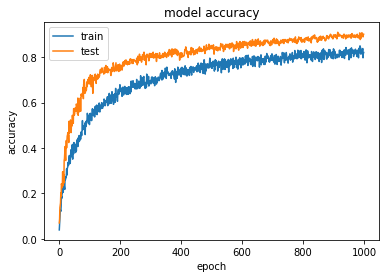

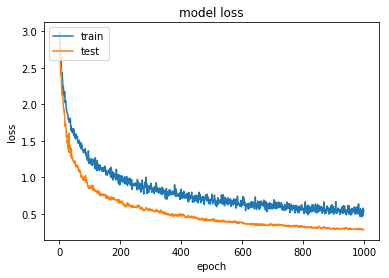

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()